# **Global Terrorism Database (GTD) - Exploratory Data Analysis**

## **Problem statement** 
The Global Terrorism Database (GTD) is an open-source database including information on terrorist attacks around the world from 1970 through 2017. The GTD includes systematic data on domestic as well as international terrorist incidents that have occurred during this time period and now includes more than 180,000 attacks. The database is maintained by researchers at the National Consortium for the Study of Terrorism and Responses to Terrorism (START), headquartered at the University of Maryland.<br>

Explore and analyze the data to discover key findings pertaining to terrorist activities. <br>

## **Tools and Libraries used**
* Pandas 
* Numpy
* Seaborn
* Matplotlib
* Plotly
* geopy
* langid
* multiprocessing

##   **1. Data Collection & Understanding** 
1.  Importing the required libraries for the operations
2.  Loading the dataset into Pandas DataFrame
3.  Look at some information about the data

### **1. Importing required libraries**

In [1]:
%config Completer.use_jedi = False

In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from geopy.geocoders import Nominatim
import langid
import multiprocessing
from multiprocessing import Pool
from plotly.offline import iplot

# Setting up plotting background
sns.set_style('darkgrid')
plt.rcParams['font.size'] = 11
plt.rcParams['figure.facecolor'] = '#00000000'

In [3]:
# for showing plots from plotly express in github
#pip install -U kaleido

# restarted the session after installing the library

In [4]:
import warnings
warnings.filterwarnings("ignore")

### **2. Loading the dataset into pandas dataframe**

In [5]:
# reading the csv file 
Global_terrorism_df  = pd.read_csv('/kaggle/input/gtd/globalterrorismdb_0718dist.csv',encoding = "ISO-8859-1")

In [6]:
# creating a copy of orginal data 
GTA_df = Global_terrorism_df.copy()

In [7]:
# Checking first 5 rows
GTA_df.head()

,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,...,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related
0,197000000001,1970,7,2,NaN,0,NaN,58,Dominican Republic,2,...,NaN,NaN,NaN,NaN,PGIS,0,0,0,0,NaN
1,197000000002,1970,0,0,NaN,0,NaN,130,Mexico,1,...,NaN,NaN,NaN,NaN,PGIS,0,1,1,1,NaN
2,197001000001,1970,1,0,NaN,0,NaN,160,Philippines,5,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
3,197001000002,1970,1,0,NaN,0,NaN,78,Greece,8,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
4,197001000003,1970,1,0,NaN,0,NaN,101,Japan,4,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN


#### **3. Checking the info. about data and columns**

In [8]:
#checking the shape of the data
GTA_df.shape

(181691, 135)

In [9]:
# Looking info
GTA_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181691 entries, 0 to 181690
Columns: 135 entries, eventid to related
dtypes: float64(55), int64(22), object(58)
memory usage: 187.1+ MB


The data types inludes float64, int64 and object

In [10]:
## Looking the columns
GTA_df.columns

Index(['eventid', 'iyear', 'imonth', 'iday', 'approxdate', 'extended',
       'resolution', 'country', 'country_txt', 'region',
       ...
       'addnotes', 'scite1', 'scite2', 'scite3', 'dbsource', 'INT_LOG',
       'INT_IDEO', 'INT_MISC', 'INT_ANY', 'related'],
      dtype='object', length=135)

In [11]:
# Since the data consists of 135 feature columns I am checking the amount of missing/null values
GTA_df.isna().sum()

eventid            0
iyear              0
imonth             0
iday               0
approxdate    172452
               ...  
INT_LOG            0
INT_IDEO           0
INT_MISC           0
INT_ANY            0
related       156653
Length: 135, dtype: int64

<AxesSubplot:>

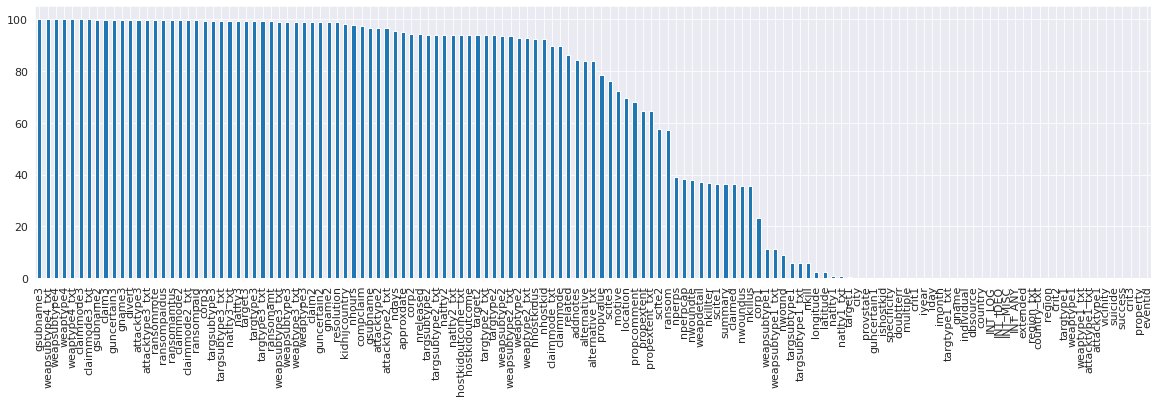

In [12]:
# Percentage of missing values per columns
plt.figure(figsize=(20, 5))
Missing_values_percent = ((GTA_df.isna().sum()/GTA_df.shape[0])*100).sort_values(ascending=False)
Missing_values_percent.plot(kind = 'bar')

In [13]:
print(f'The number of columns which have more than 50% of null values are:{ len(Missing_values_percent [Missing_values_percent >= 50])}')

The number of columns which have more than 50% of null values are:77


In [14]:
# Columns which doesnot contain more than 50% null values
Missing_values_percent [~(Missing_values_percent >= 50)].index

Index(['nperps', 'nperpcap', 'nwoundte', 'weapdetail', 'nkillter', 'scite1',
       'summary', 'claimed', 'nwoundus', 'nkillus', 'corp1', 'weapsubtype1',
       'weapsubtype1_txt', 'nwound', 'targsubtype1', 'targsubtype1_txt',
       'nkill', 'longitude', 'latitude', 'natlty1', 'natlty1_txt', 'target1',
       'city', 'provstate', 'guncertain1', 'ishostkid', 'specificity',
       'doubtterr', 'multiple', 'crit1', 'iyear', 'iday', 'imonth',
       'targtype1_txt', 'gname', 'individual', 'dbsource', 'country',
       'INT_LOG', 'INT_IDEO', 'INT_MISC', 'INT_ANY', 'extended', 'region_txt',
       'country_txt', 'region', 'crit2', 'targtype1', 'weaptype1',
       'weaptype1_txt', 'attacktype1_txt', 'attacktype1', 'vicinity',
       'suicide', 'success', 'crit3', 'property', 'eventid'],
      dtype='object')

##   **2. Data Cleaning and Manipulations** 
1.   Feature selection <br>
2.   Removing duplicated rows if any <br>
3.   Fixing incorrect values if any <br>
4.   Handling the missing values (multiprocessing applied)<br>
5.   Looking the datatypes
6.   Adding new feature columns if required<br>

#### **1. Feature Selections**
From the 135 columns Iam considering only following columns for my analyis: 
* eventid -  All the incidents are represented by 12-digit Event ID system 
            • First 8 numbers – date recorded “yyyymmdd”.
            • Last 4 numbers – sequential case number for the given day (0001, 0002 etc).
* iyear - year in which the incident occurred
* imonth - number of the month in which the incident occurred
* iday - day of the month on which the incident occurred
* extended  
        1 = "Yes" The duration of an incident extended more than 24 hours. 
        0 = "No" The duration of an incident extended less than 24 hours.
* country_txt -  country or location where the incident occurred
* region_txt -  region in which the incident occurred (12 regions are here in the data)
* city - name of the city, village, or town in which the incident occurred
* latitude -  latitude (based on WGS1984 standards) of the city where the event occurred
* longitude -  longitude (based on WGS1984 standards) of the city where the event occurred
* success - Success of a terrorist strike is defined according to the tangible effects of the attack
        1 = "Yes" The incident was successful. 
        0 = "No" The incident was not successful
* attacktype1_txt -  general method of attack and often reflects the broad class of tactics used
* targtype1_txt - general type of target/victim
* corp1 - Name of entity that was targeted
* target1 -  specific person, building, installation, etc.that was targeted and/or victimized and is a part of the entity named above
* natlty1_txt - This is the nationality of the target that was attacked, and is not necessarily the same as the  country in which the incident occurred, although in most cases it is. For hijacking incidents, the nationality of the plane is recorded and not that of the passengers
* targsubtype1_txt - The target subtype variable captures the more specific target category and provides the next level of designation for each target type.
* gname - name of the group that carried out the attack
* weaptype1_txt - types of the weapons used in an attack
* nkill -  number of total confirmed fatalities
* nwound - number of confirmed non-fatal injuries to both perpetrators and victims.
* property - Property Damage
        1 = "Yes" The incident resulted in property damage. 
        0 = "No" The incident did not result in property damage.
        -9 = "Unknown"


In [15]:
# Selecting only required features from the above data for further analysis 
keep_cols = ['eventid', 'iyear', 'imonth', 'iday', 'extended','country_txt','region_txt','city', 'latitude',
       'longitude','success','attacktype1_txt', 'targtype1_txt','corp1', 'target1','natlty1_txt','targsubtype1_txt',
       'gname','weaptype1_txt','nkill','nwound','property']

# creating a new dataframe with selected features 
GTA_df_new = GTA_df[keep_cols]

In [16]:
# Renaming the selected columns
GTA_df_new.rename(columns = {'iyear':'year','imonth':'month','iday':'day','country_txt':'country','region_txt':'region',
                           'attacktype1_txt':'attack_type','targtype1_txt':'victim_cata','target1':'specific_victim','targsubtype1_txt':'victim_subtype_cata',
                           'corp1':'entity_name','natlty1_txt':'victim_nationaliy','gname':'perpetrator_group','weaptype1_txt':'weapon','nkill':'num_fatalities',
                           'nwound':'num_injured'},inplace = True)

In [17]:
# New dataframe
GTA_df_new.head()

,eventid,year,month,day,extended,country,region,city,latitude,longitude,...,victim_cata,entity_name,specific_victim,victim_nationaliy,victim_subtype_cata,perpetrator_group,weapon,num_fatalities,num_injured,property
0,197000000001,1970,7,2,0,Dominican Republic,Central America & Caribbean,Santo Domingo,18.456792,-69.951164,...,Private Citizens & Property,NaN,Julio Guzman,Dominican Republic,Named Civilian,MANO-D,Unknown,1.0,0.0,0
1,197000000002,1970,0,0,0,Mexico,North America,Mexico city,19.371887,-99.086624,...,Government (Diplomatic),Belgian Ambassador Daughter,"Nadine Chaval, daughter",Belgium,"Diplomatic Personnel (outside of embassy, cons...",23rd of September Communist League,Unknown,0.0,0.0,0
2,197001000001,1970,1,0,0,Philippines,Southeast Asia,Unknown,15.478598,120.599741,...,Journalists & Media,Voice of America,Employee,United States,Radio Journalist/Staff/Facility,Unknown,Unknown,1.0,0.0,0
3,197001000002,1970,1,0,0,Greece,Western Europe,Athens,37.997490,23.762728,...,Government (Diplomatic),NaN,U.S. Embassy,United States,Embassy/Consulate,Unknown,Explosives,NaN,NaN,1
4,197001000003,1970,1,0,0,Japan,East Asia,Fukouka,33.580412,130.396361,...,Government (Diplomatic),NaN,U.S. Consulate,United States,Embassy/Consulate,Unknown,Incendiary,NaN,NaN,1


In [18]:
# recheking the shape
GTA_df_new.shape

(181691, 22)

In [19]:
# Describing numeric columns in the dataframe (float64 & int64)
GTA_df_new.describe().T

,count,mean,std,min,25%,50%,75%,max
eventid,181691.0,2.002705e+11,1.325957e+09,1.970000e+11,1.991021e+11,2.009022e+11,2.014081e+11,2.017123e+11
year,181691.0,2.002639e+03,1.325943e+01,1.970000e+03,1.991000e+03,2.009000e+03,2.014000e+03,2.017000e+03
month,181691.0,6.467277e+00,3.388303e+00,0.000000e+00,4.000000e+00,6.000000e+00,9.000000e+00,1.200000e+01
day,181691.0,1.550564e+01,8.814045e+00,0.000000e+00,8.000000e+00,1.500000e+01,2.300000e+01,3.100000e+01
extended,181691.0,4.534622e-02,2.080629e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
latitude,177135.0,2.349834e+01,1.856924e+01,-5.315461e+01,1.151005e+01,3.146746e+01,3.468509e+01,7.463355e+01
longitude,177134.0,-4.586957e+02,2.047790e+05,-8.618590e+07,4.545640e+00,4.324651e+01,6.871033e+01,1.793667e+02
success,181691.0,8.895983e-01,3.133907e-01,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
num_fatalities,171378.0,2.403272e+00,1.154574e+01,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00,1.570000e+03
num_injured,165380.0,3.167668e+00,3.594939e+01,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00,8.191000e+03


In [20]:
# Describing the object columns in the dataframe
GTA_df_new.describe(include = 'object').T

,count,unique,top,freq
country,181691,205,Iraq,24636
region,181691,12,Middle East & North Africa,50474
city,181257,36674,Unknown,9775
attack_type,181691,9,Bombing/Explosion,88255
victim_cata,181691,22,Private Citizens & Property,43511
entity_name,139141,33238,Unknown,16356
specific_victim,181055,86006,Civilians,6461
victim_nationaliy,180132,215,Iraq,24113
victim_subtype_cata,171318,112,Unnamed Civilian/Unspecified,11596
perpetrator_group,181691,3537,Unknown,82782


In [21]:
GTA_df_new.columns

Index(['eventid', 'year', 'month', 'day', 'extended', 'country', 'region',
       'city', 'latitude', 'longitude', 'success', 'attack_type',
       'victim_cata', 'entity_name', 'specific_victim', 'victim_nationaliy',
       'victim_subtype_cata', 'perpetrator_group', 'weapon', 'num_fatalities',
       'num_injured', 'property'],
      dtype='object')

In [22]:
# Exploring unique elements in the selected columns 
selected_cols = ['year', 'month', 'day', 'extended', 'country', 'region',
               'city', 'success', 'attack_type', 'victim_cata', 'entity_name',
               'specific_victim', 'victim_nationaliy','victim_subtype_cata', 
               'perpetrator_group', 'weapon']
for column_name in selected_cols:
    print(GTA_df_new[column_name].unique())

[1970 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1986 1982
 1983 1984 1985 1987 1988 1989 1990 1991 1992 1994 1995 1996 1997 1998
 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012
 2013 2014 2015 2016 2017]
[ 7  0  1  2  3  4  5  6  8  9 10 11 12]
[ 2  0  1  3  6  8  9 10 11 12 13 14 15 19 20 21 22 25 26 27 28 30 31  4
  7 16 17 18 23 24  5 29]
[0 1]
['Dominican Republic' 'Mexico' 'Philippines' 'Greece' 'Japan'
 'United States' 'Uruguay' 'Italy' 'East Germany (GDR)' 'Ethiopia'
 'Guatemala' 'Venezuela' 'West Germany (FRG)' 'Switzerland' 'Jordan'
 'Spain' 'Brazil' 'Egypt' 'Argentina' 'Lebanon' 'Ireland' 'Turkey'
 'Paraguay' 'Iran' 'United Kingdom' 'Colombia' 'Bolivia' 'Nicaragua'
 'Netherlands' 'Belgium' 'Canada' 'Australia' 'Pakistan' 'Zambia' 'Sweden'
 'Costa Rica' 'South Yemen' 'Cambodia' 'Israel' 'Poland' 'Taiwan' 'Panama'
 'Kuwait' 'West Bank and Gaza Strip' 'Austria' 'Czechoslovakia' 'India'
 'France' 'South Vietnam' 'Brunei' 'Zaire'
 "People's Repu

* The data includes different years from 1970-2017, except 1993
* There are some incorrect values are present in <code>month</code> and <code>day</code> column

#### **2. Removing duplicated rows if any** 

In [23]:
# Rows containing duplicate values
GTA_df_new[GTA_df_new.duplicated()]

,eventid,year,month,day,extended,country,region,city,latitude,longitude,...,victim_cata,entity_name,specific_victim,victim_nationaliy,victim_subtype_cata,perpetrator_group,weapon,num_fatalities,num_injured,property


 Great! There are no duplicated rows are present in the dataset.

#### **3. Fixing incorrect values.**

* Both the <code>month</code> and <code>day</code> columns includes value 0
* The <code>city</code> column contains both the 'unknown' and 'Unknown' values. 

In [24]:
# checking out the columns that contains 0 values for day and month 
GTA_df_new[(GTA_df_new.month == 0) | (GTA_df_new.day ==0)].shape

(891, 22)

There are 891 rows found to be present in the dataset that has 0 values provided for the month and day columns.

In [25]:
# Number of unique value counts in both month and day columns
GTA_df_new['month'].value_counts().sort_values(ascending= False)

5     16875
7     16268
8     15800
10    15563
6     15359
3     15257
4     15152
1     14936
11    14906
9     14180
2     13879
12    13496
0        20
Name: month, dtype: int64

In [26]:
GTA_df_new['day'].value_counts().sort_values(ascending= False)

15    6500
1     6344
4     6153
16    6112
10    6064
9     6057
13    6043
14    6028
28    6027
12    6012
3     6011
7     5997
19    5973
2     5954
27    5937
11    5936
20    5930
18    5880
25    5875
8     5859
17    5852
5     5844
21    5827
26    5823
22    5799
23    5782
6     5781
24    5752
29    5507
30    5046
31    3095
0      891
Name: day, dtype: int64

The incorrect values are replaced with the most frequent value in the city column.

In [27]:
# replacing 0 values in the month column with 12
GTA_df_new.month.replace(0,5 , inplace = True)

# replacing 0 values in the day column with 15
GTA_df_new.day.replace(0,15, inplace = True)

In [28]:
# checking the number of both 'Unknown','unknown' & null values in the city column.
print(GTA_df_new[GTA_df_new.city == 'Unknown']['city'].count())
print(GTA_df_new[GTA_df_new.city == 'unknown']['city'].count())
print(len(GTA_df_new[GTA_df_new.city.isna() == True]['city']))

9775
47
434


There are 9775 rows found to be in the <code>city</code> which is named <mark>'Unknown'</mark> and 47 values for <mark>'unknown'</mark>. So correcting these incorrect values in the data by temporarly replacing all these values including Null values with 'Unknown'.

In [29]:
GTA_df_new.city = GTA_df_new.city.replace('unknown','Unknown')

#### **4. Handling Missing values**

* Null values in the columns <code>num_injured</code> and <code>num_fatalities</code> were replaced with forward filling. <br>
* Null values in the columns <code>entity_name</code> , <code>specific_victim</code> ,and <code>victim_nationaliy</code> were replaced wih 'Unknown'.<br>
* Null values in the <code>victim_subtype_cata</code> were replaced with 'Unnamed Civilian/Unspecified'.<br>
* The maximum 'Unknown'& Null values in the <code>city</code>,<code>longitude</code> and <code>latitude</code> column is finding out by using geopy and langid libraries. <br>
* The Null values in the <code>longitude</code> and <code>latitude</code> columns that are not able to find out are dropping out from the dataframe.

In [30]:
# checking the null values in each column in percentage
missing_values = ((GTA_df_new.isna().sum()/GTA_df_new.shape[0])*100).sort_values(ascending= False)
missing_values

entity_name            23.418882
num_injured             8.977330
victim_subtype_cata     5.709144
num_fatalities          5.676120
longitude               2.508104
latitude                2.507554
victim_nationaliy       0.858050
specific_victim         0.350045
city                    0.238867
eventid                 0.000000
weapon                  0.000000
perpetrator_group       0.000000
attack_type             0.000000
victim_cata             0.000000
year                    0.000000
success                 0.000000
region                  0.000000
country                 0.000000
extended                0.000000
day                     0.000000
month                   0.000000
property                0.000000
dtype: float64

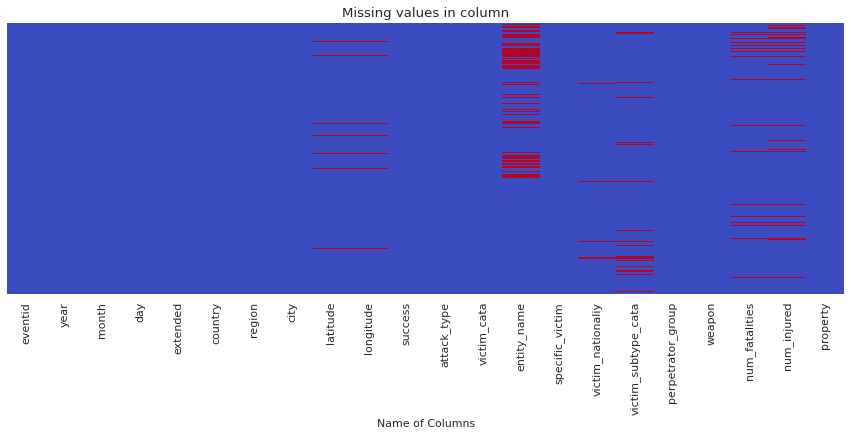

In [31]:
# Visualizing null values through heatmap.
plt.figure(figsize=(15, 5))
sns.heatmap(GTA_df_new.isnull(), cbar=False, yticklabels=False,cmap='coolwarm')
plt.xlabel("Name of Columns")
plt.title("Missing values in column")
plt.show()

In [32]:
### Filling the missing values 
GTA_df_new[['num_injured','num_fatalities']] = GTA_df_new[['num_injured','num_fatalities']].fillna(method='ffill')
GTA_df_new[['entity_name','specific_victim','victim_nationaliy']] =GTA_df_new[['entity_name','specific_victim','victim_nationaliy']].fillna('Unknown')
GTA_df_new['victim_subtype_cata'] = GTA_df_new['victim_subtype_cata'].fillna('Unnamed Civilian/Unspecified')

In [33]:
# temporarily filling all the missing values in the city column with 'Unknowns'
GTA_df_new['city'] = GTA_df_new['city'].fillna('Unknown')
percent_city_unknown = len(GTA_df_new[GTA_df_new.city =='Unknown'])/len(GTA_df_new)*100

# checking the value counts in city column
GTA_df_new.city.value_counts()

Unknown      10256
Baghdad       7589
Karachi       2652
Lima          2359
Mosul         2265
             ...  
Hotwag           1
Ostend           1
Balughata        1
Jikoyi           1
Kubentog         1
Name: city, Length: 36673, dtype: int64

In [34]:
print(f'The percentage of total "Unknown" values in the city column {percent_city_unknown}')

The percentage of total "Unknown" values in the city column 5.644748501576853


Since most frequent value in the <code>city</code> column is 'Unknown', I am using geopy and langid libraries for finding out the city names by considering non-null values from <code>longitude</code> and <code>latitude</code> columns.

In [35]:
## Finding out the observations where city column is Unknown' ,longitude & latitude values are not null
unknown_city_data = GTA_df_new[(GTA_df_new['longitude'].isna()== False) & (GTA_df_new['latitude'].isna()== False) & (GTA_df_new['city'] == 'Unknown')][['longitude','latitude','city']]
unknown_city_data.head()

,longitude,latitude,city
2,120.599741,15.478598,Unknown
705,49.536102,37.146795,Unknown
1007,-6.086832,54.552254,Unknown
1085,119.583330,23.583333,Unknown
1222,121.965256,17.092014,Unknown


In [36]:
print(f'Total number of observations whose city column is "Unknown",latitude and longitude values are not null is: {len(unknown_city_data)}')

Total number of observations whose city column is "Unknown",latitude and longitude values are not null is: 7961


#### Multiprocessing for finding out unknown values from city column

In [37]:
# geolocator = Nominatim(user_agent="http")

# def update_city(row):
#     try:
#         Longitude = str(row['longitude'])
#         Latitude = str(row['latitude'])
#         location = geolocator.reverse(Latitude+","+Longitude, exactly_one=True)
#         address = location.raw['address']
#         city = address.get('city', '')

#     ### Selecting the city name only in english language
#         if langid.classify(city)[0] =='en':
#             row['city'] = row['city'].replace('Unknown', str(city))
#         else:
#             row['city'] = row['city']
#         return row
    
#     except Exception as e:
#         print(e)
        
        
# def update_city2(df):
#     df2 = df.apply(update_city , axis = 1)
#     return df2


# df1 = unknown_city_data[0:2000]
# df2 = unknown_city_data[2000:4000]   

# if __name__ == '__main__':
#     df = unknown_city_data
#     p = Pool()
#     result = p.map(update_city2,[df1,df2
#                                  ])
#     p.close()
#     p.join()
#     print(result)

In [38]:
#pd.concat(result,axis =0).to_csv('Geocoder_city.csv')

In [39]:
# df1 = unknown_city_data[4000:6000]
# df2 = unknown_city_data[6000:]   

# if __name__ == '__main__':
#     df = unknown_city_data
#     p = Pool()
#     result = p.map(update_city2,[df1,df2
#                                  ])
#     p.close()
#     p.join()
#     print(result)

In [40]:
#pd.concat(result,axis =0).to_csv('Geocoder_city1.csv')

In [41]:
#Geocoder_data_part1 = pd.read_csv('./Geocoder_city.csv')
#Geocoder_data_part2 = pd.read_csv('./Geocoder_city1.csv')

Geocoder_data_part1 = pd.read_csv('/kaggle/input/output-data/Geocoder_city.csv')
Geocoder_data_part2 = pd.read_csv('/kaggle/input/output-data/Geocoder_city1.csv')

city_data = pd.concat([Geocoder_data_part1,Geocoder_data_part2],axis = 0).set_index('Unnamed: 0')
city_data = city_data[(city_data.city !='Unknown') & (city_data.city.notnull())]

In [42]:
city_data.head()

,longitude,latitude,city
Unnamed: 0,,,
2,120.599741,15.478598,Tarlac City
1007,-6.086832,54.552254,Lisburn
3393,121.972109,6.705778,Isabela
3628,121.972109,6.705778,Isabela
6340,140.717000,-2.533000,Jayapura


In [43]:
### Function for updating the city column in orginal dataframe
def change_city(df1,df2):
    for i in df2.index:
        if i in df1.index:
            df1.loc[i, ['city']] = df2.loc[i,'city'] 
    return df1

In [44]:
change_city(GTA_df_new,city_data).head()

,eventid,year,month,day,extended,country,region,city,latitude,longitude,...,victim_cata,entity_name,specific_victim,victim_nationaliy,victim_subtype_cata,perpetrator_group,weapon,num_fatalities,num_injured,property
0,197000000001,1970,7,2,0,Dominican Republic,Central America & Caribbean,Santo Domingo,18.456792,-69.951164,...,Private Citizens & Property,Unknown,Julio Guzman,Dominican Republic,Named Civilian,MANO-D,Unknown,1.0,0.0,0
1,197000000002,1970,5,15,0,Mexico,North America,Mexico city,19.371887,-99.086624,...,Government (Diplomatic),Belgian Ambassador Daughter,"Nadine Chaval, daughter",Belgium,"Diplomatic Personnel (outside of embassy, cons...",23rd of September Communist League,Unknown,0.0,0.0,0
2,197001000001,1970,1,15,0,Philippines,Southeast Asia,Tarlac City,15.478598,120.599741,...,Journalists & Media,Voice of America,Employee,United States,Radio Journalist/Staff/Facility,Unknown,Unknown,1.0,0.0,0
3,197001000002,1970,1,15,0,Greece,Western Europe,Athens,37.997490,23.762728,...,Government (Diplomatic),Unknown,U.S. Embassy,United States,Embassy/Consulate,Unknown,Explosives,1.0,0.0,1
4,197001000003,1970,1,15,0,Japan,East Asia,Fukouka,33.580412,130.396361,...,Government (Diplomatic),Unknown,U.S. Consulate,United States,Embassy/Consulate,Unknown,Incendiary,1.0,0.0,1


In [45]:
GTA_df_new.city.value_counts()

Unknown           9949
Baghdad           7589
Karachi           2652
Lima              2362
Mosul             2265
                  ... 
Montalban            1
Enugu Ukwu           1
Sukanguri            1
Fila el Atillo       1
Kubentog             1
Name: city, Length: 36690, dtype: int64

Well! Now the total 'Unknown' observations in the <code>city</code> column have been reduced.But still method of finding city from latitude and longitudes has not worked well for this data.

In [46]:
((GTA_df_new.isna().sum()/GTA_df_new.shape[0])*100).sort_values(ascending= False)[:2]

longitude    2.508104
latitude     2.507554
dtype: float64

Again I am trying to find out the null values in <code>longitude</code> and <code>latitude</code> by using geopy library considering <code>city</code> , <code>region</code> columns.

In [47]:
### checking out is there any missing values present in lat and long columns where city and region is not null
lat_long_missing = GTA_df_new[(GTA_df_new['longitude'].isna()== True) & 
                             (GTA_df_new['latitude'].isna()== True) & 
                             (GTA_df_new['city']!= 'Unknown') &     
                             (GTA_df_new['country']!= 'Unknown')][['longitude','latitude','city','country']]
len(lat_long_missing)

2261

In [48]:
lat_long_missing.head()

,longitude,latitude,city,country
210,NaN,NaN,Cauayan,Philippines
739,NaN,NaN,Tarlas,Philippines
2400,NaN,NaN,Ghinda,Ethiopia
2941,NaN,NaN,San Juan del Carare,Colombia
3169,NaN,NaN,Cavanilles,Spain


In [49]:
#### General function for finding out latitude and longitude from city and region data.
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="my_user_agent")
def find_lat_long(row):
    try:
        city = str(row['city'])
        country = str(row['country'])
        loc = geolocator.geocode(city+','+ country)
        row['longitude'] = loc.longitude
        row['latitude'] = loc.latitude
        return row
    except:
         pass

In [50]:
#lat_long_missing_df = lat_long_missing.apply(find_lat_long,axis=1)
lat_long_missing_df = pd.read_csv('/kaggle/input/output-data1/lat_long_data.csv')

In [51]:
lat_long_missing_df = lat_long_missing_df[~lat_long_missing_df.longitude.isna()].set_index('Unnamed: 0')
lat_long_missing_df.head()

,longitude,latitude,city,country_name
Unnamed: 0,,,,
210,121.774390,16.933503,Cauayan,Philippines
2400,40.350000,4.200000,Ghinda,Ethiopia
3169,-0.583848,38.619806,Cavanilles,Spain
4941,-0.721047,37.929421,Calla,Spain
5331,-75.537811,9.907504,Barranca,Colombia


In [52]:
lat_long_missing_df.count()

longitude       909
latitude        909
city            909
country_name    909
dtype: int64

In [53]:
# function for updating the orginal dataframe
def replace_missing_lat_long(df1,df2):
    for i in df2.index:
        if i in df1.index:
            df1.loc[i, ['longitude']] = df2.loc[i,'longitude']
            df1.loc[i, ['latitude']] = df2.loc[i,'latitude']
        else:
            pass
    return df1

In [54]:
replace_missing_lat_long(GTA_df_new,lat_long_missing_df).head()

,eventid,year,month,day,extended,country,region,city,latitude,longitude,...,victim_cata,entity_name,specific_victim,victim_nationaliy,victim_subtype_cata,perpetrator_group,weapon,num_fatalities,num_injured,property
0,197000000001,1970,7,2,0,Dominican Republic,Central America & Caribbean,Santo Domingo,18.456792,-69.951164,...,Private Citizens & Property,Unknown,Julio Guzman,Dominican Republic,Named Civilian,MANO-D,Unknown,1.0,0.0,0
1,197000000002,1970,5,15,0,Mexico,North America,Mexico city,19.371887,-99.086624,...,Government (Diplomatic),Belgian Ambassador Daughter,"Nadine Chaval, daughter",Belgium,"Diplomatic Personnel (outside of embassy, cons...",23rd of September Communist League,Unknown,0.0,0.0,0
2,197001000001,1970,1,15,0,Philippines,Southeast Asia,Tarlac City,15.478598,120.599741,...,Journalists & Media,Voice of America,Employee,United States,Radio Journalist/Staff/Facility,Unknown,Unknown,1.0,0.0,0
3,197001000002,1970,1,15,0,Greece,Western Europe,Athens,37.997490,23.762728,...,Government (Diplomatic),Unknown,U.S. Embassy,United States,Embassy/Consulate,Unknown,Explosives,1.0,0.0,1
4,197001000003,1970,1,15,0,Japan,East Asia,Fukouka,33.580412,130.396361,...,Government (Diplomatic),Unknown,U.S. Consulate,United States,Embassy/Consulate,Unknown,Incendiary,1.0,0.0,1


In [55]:
# Looking the missing values for the latitude and longitude columns
((GTA_df_new[['longitude','latitude']].isna().sum()/GTA_df_new.shape[0])*100).sort_values(ascending= False)

longitude    2.007804
latitude     2.007254
dtype: float64

Still the method of finding the latitude and longitude from the city and region data has not made significant difference in this data. This is because ,some strings in <code>city</code> or <code>region</code> columns are not in standardized spelling.<br>
But however above two methods worked well for some part of data.
I am using whatever the values that I could findout through the above function. Remaing 2 percentage of latitude and longitude unknown values are dropping out from the data. 

In [56]:
# Dropping remaining missing values in latitude and longitude column
GTA_df_new = GTA_df_new.dropna()

#### **5. Looking the datatypes of columns**
* Changing the datatypes of <code>num_fatalities</code> and <code>num_injured</code> to int64.

In [57]:
GTA_df_new.dtypes

eventid                  int64
year                     int64
month                    int64
day                      int64
extended                 int64
country                 object
region                  object
city                    object
latitude               float64
longitude              float64
success                  int64
attack_type             object
victim_cata             object
entity_name             object
specific_victim         object
victim_nationaliy       object
victim_subtype_cata     object
perpetrator_group       object
weapon                  object
num_fatalities         float64
num_injured            float64
property                 int64
dtype: object

In [58]:
# updating the datatype
GTA_df_new = GTA_df_new.astype({'num_fatalities':'int64','num_injured':'int64'})

#### **6. Creating new feature column**
Creating a new column <code>num_casualities</code> by adding <code>num_fatalities</code> and <code>num_injured</code>


In [59]:
GTA_df_new['num_casualities'] = GTA_df_new['num_fatalities']+ GTA_df_new['num_injured']

#### **3. Fixing incorrect values.(continue from above)**
##### **Checking the relationships between 'property','num_casualities' and 'success' columns.**
I am explicitly checking whether any observations are present in the data with the following conditions:<br>
<code>num_casualities == 0 & property == 0 & success ==1</code> <br>
Such columns are considered incorrect values. If any such columns are present in the data we may have to do some further treatment for such wrong values. An attack is reported as successful only when either the perpetrator is succeed in damaging the targeted property or creating casualties.


Text(0.5, 1.0, 'Types of property damage during attacks')

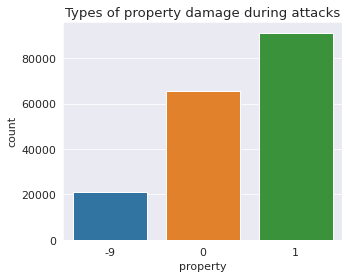

In [60]:
# Exploring 'property' feature
plt.figure(figsize=(5,4))
sns.countplot('property', data=GTA_df_new)
plt.title('Types of property damage during attacks')

In [61]:
# checking the condition : num_casualities == 0 & property == 0 & success ==1
GTA_df_new[(GTA_df_new.num_casualities ==0) & (GTA_df_new.property == 0)]['success'].value_counts()

0    10716
1     7811
Name: success, dtype: int64

There were 18527 attacks that took place which didn't cause any casualties as well as property damages. But among these data 7811 attacks are recorded as successful. This means 7811 records were reported as successful which causes 0 casualties and 0 property damages. In such cases, we are checking the types of weapons used.


In [62]:
GTA_df_new.loc[(GTA_df_new.property == 0) & 
               (GTA_df_new.num_casualities == 0) & 
               (GTA_df_new.success == 1)]['weapon'].value_counts()

Explosives            2797
Unknown               2534
Firearms              2281
Melee                   87
Incendiary              81
Fake Weapons            16
Chemical                 9
Other                    4
Sabotage Equipment       2
Name: weapon, dtype: int64

In both the explosives and firearms cases, most probably there can be property damage, wounds even deaths can occur. But in this data, I am assigning property damages to the obsevations that satisfies above condition.

In [63]:
# Updating the property damages in the above columns
GTA_df_new['property'] = np.where(((GTA_df_new.property == 0)& 
                              (GTA_df_new.num_casualities == 0) & 
                              (GTA_df_new.success == 1)),1,GTA_df_new.property)

Text(0.5, 1.0, 'Types of property damage during attacks')

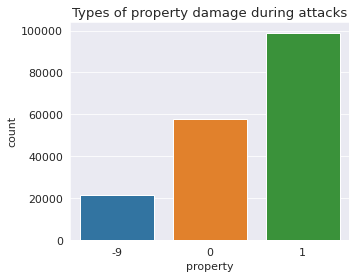

In [64]:
# checking the property damage column again for confirming the data frame has been updated.
plt.figure(figsize=(5,4))
sns.countplot('property', data=GTA_df_new)
plt.title('Types of property damage during attacks')

Great! Now the values has been updated.<br>
**Now our data is ready for analysis**

#### **Correlation Plot**

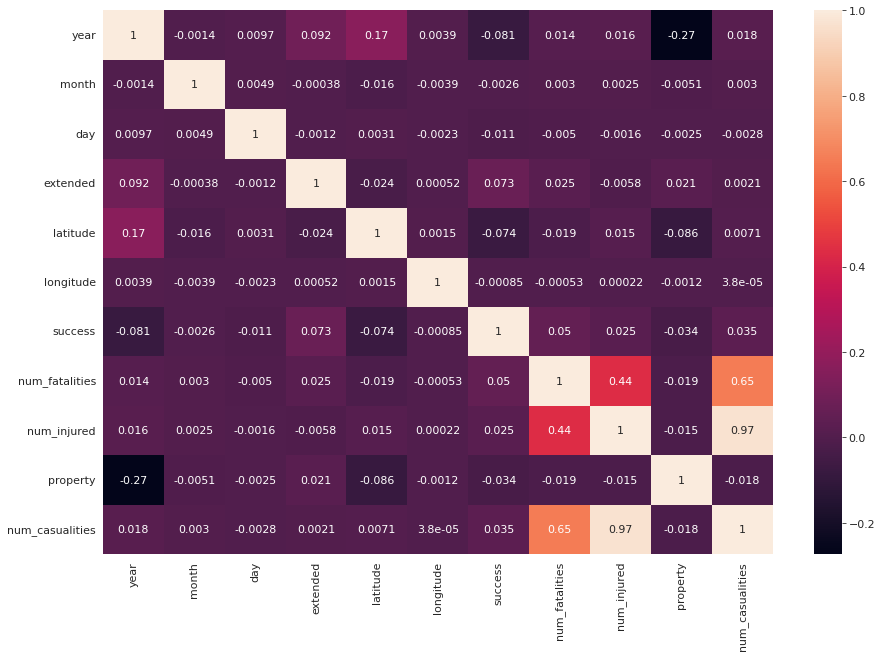

In [65]:
plt.figure(figsize=(15,10))
sns.heatmap(GTA_df_new.drop('eventid',axis = 1).corr(), annot= True)
plt.show()

* <code>num_fatalities</code> and <code>num_casualities</code> are moderately correlated. This means with an increase in fatality number the total casualties also increase.
* <code>num_fatalities</code> and <code>num_injured</code> are moderately correlated.

## **3. Exploratory Data Analysis & Visualizations**
### **Univariate Analysis | Bivariate Analysis |  Multivariate Analysis**

### 1. What percentage of total attacks had extended more than 24 hours?

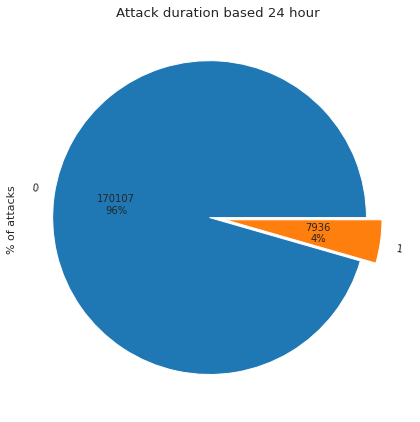

In [66]:
# Function for customised labelling 
def label_function(val):
    return f'{val / 100 * len(GTA_df_new):.0f}\n{val:.0f}%'

# Ploting the values
plt.figure(figsize=(6,6))
GTA_df_new.groupby('extended').size().plot(kind='pie',
                                 autopct=label_function,
                                 textprops={'fontsize': 10},explode=[0.05]*2,
                                 rotatelabels=True , 
                                 title = 'Attack duration based 24 hour')
plt.tight_layout()
plt.ylabel('% of attacks')
plt.show()

##### **Findings from the above graph**
<code>Only 4% of attacks extendended more than 24 hours</code>. In numbers it counted below 8000.

### 2. Percentage of successful and unsuccessful attacks

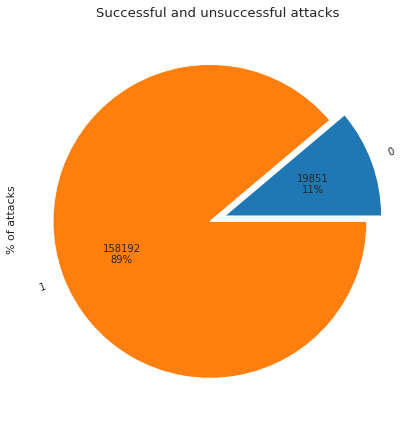

In [67]:
# Ploting the values
plt.figure(figsize=(6,6))
GTA_df_new.groupby('success').size().plot(kind='pie',
                                 autopct=label_function,
                                 textprops={'fontsize': 10},explode=[0.05]*2,
                                 rotatelabels=True,
                                 title = 'Successful and unsuccessful attacks')
plt.tight_layout()
plt.ylabel('% of attacks')
plt.show()

##### **Findings from the above graph**
* <code> 89% </code>of total attacks that happened all over the world during the period of time 1970 -2017 were reported as successful. 

### 3. Do the trend in attacks varies with respect to a particular month?

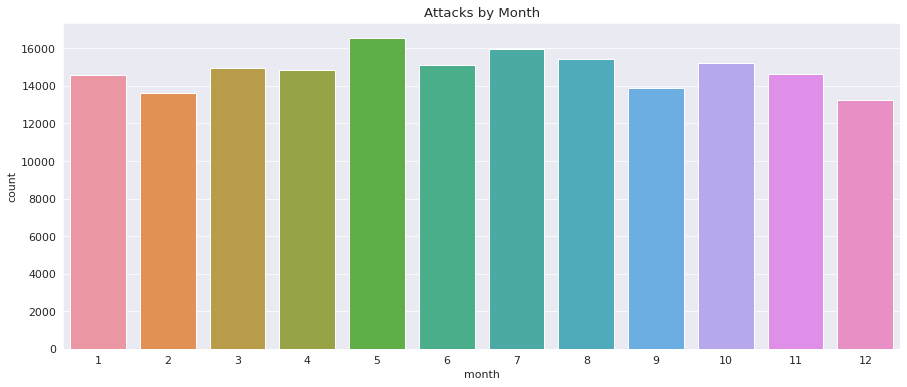

In [68]:
plt.figure(figsize=(15,6))
sns.countplot(x = 'month',data=GTA_df_new)
plt.title('Attacks by Month')
plt.show()

##### **Findings from the above graph**
* Almost every month has the same contribution

### 4. Identify the trend in attack over the years. Which year had the highest & lowest number of attacks?

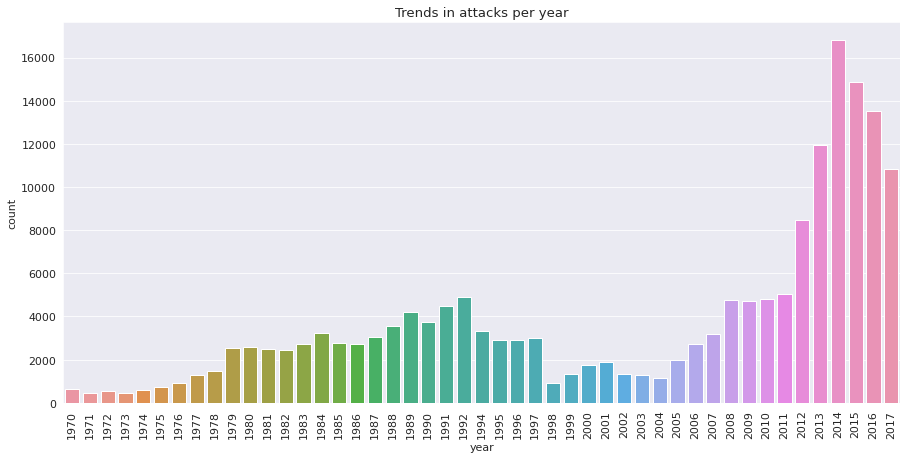

In [69]:
plt.figure(figsize=(15,7))
sns.countplot(x=GTA_df_new.year)
plt.title('Trends in attacks per year')
plt.xticks(rotation = 90)
plt.show()

##### **Findings from the above graph**
* The period <code>2012 - 17</code>  had the <code>highest</code> period of attacks per year (>10,000). 
* Year <code>2014 had the most number of attacks</code>(<16000).
* The period <code>1970 - 76</code> shows the <code>lowest</code> period of attacks (>1000). 
* <code>1971 and 1973</code> show the <code>lowest numbers</code> of attacks.

### 5. Global impact of terrorism

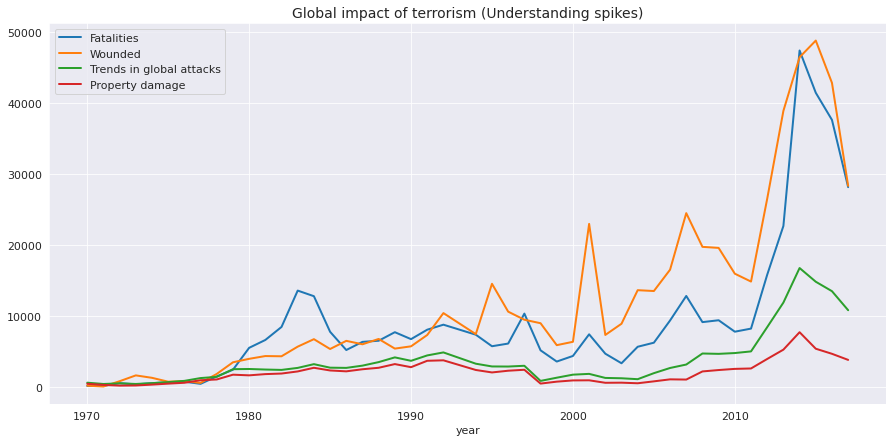

In [70]:
plt.figure(figsize=(15,7))
ax1 = plt.subplot(111)
plt.title('Global impact of terrorism (Understanding spikes)', size = 14)

GTA_df_new.groupby('year')['num_fatalities'].sum().plot(linewidth=2,
                                                        ax=ax1,
                                                        sharex = True,
                                                        sharey = True,
                                                        label = 'Fatalities')

GTA_df_new.groupby('year')['num_injured'].sum().plot(linewidth=2,
                                                     ax=ax1,
                                                     sharex = True,
                                                     sharey = True,
                                                     label = 'Wounded' )

GTA_df_new.groupby('year')['eventid'].count().plot(linewidth=2,
                                                   ax=ax1,
                                                   sharex = True,
                                                   sharey = True,
                                                   label = 'Trends in global attacks')

GTA_df_new[GTA_df_new.property  == 1].groupby('year')['property'].sum().plot(linewidth=2, 
                                                                             ax=ax1,
                                                                             sharex = True,
                                                                             sharey = True,
                                                                             label = 'Property damage')
plt.legend()
plt.show()

##### **Findings from the above graph**
* From <code>2011-14</code> , <code>attacks have increased by 232%</code>, </code>related deaths has increased by 474%</code>,and <code>confirmed wounds has increased by 212%</code> and <code>property damages has increased to approx.193%</code>.
* Although <code>related deaths & property damages have declined since 2015</code> with respect to the number of attacks but <code>related wounds have increased to 5% from 2014</code>.

### 6. Identify the 50 targeted cities in the history

In [71]:
target_cities = GTA_df_new[GTA_df_new.city != 'Unknown'].groupby(['city'])['eventid'].count().sort_values(ascending= False)[:50].to_frame()

# Plotting
data = [{
        'x': target_cities.index,
        'y': target_cities['eventid'].values,
        'mode': 'markers',
        'marker': {
            'sizemode': 'area',
            'size': target_cities['eventid'].values}
                                                   }]
iplot(data)

##### **Findings from the above graph**
* The capital of Iraq, the second largest city in the Arab world <code>Baghdad was the most targeted</code> city in the world.
* Followed by Karachi in Pakisthan,Lima in Peru, Mosul and Belfast are victimized more than 2000 times.
* Baghdad alone was targeted more than 7,500 times.
* Karachi,Lima and Mosul combined had less than 7,500 attacks.

### 7. Top 5 active terrorist groups in the most affected city (Baghdad)

In [72]:
# top targeted groups in Baghdad
baghdad_df = GTA_df_new[GTA_df_new.city == 'Baghdad']
attack_num  = baghdad_df.groupby('perpetrator_group')['eventid'].count().sort_values(ascending = False)
attacks_percent = (attack_num/len(baghdad_df))*100 
attacks_percent.head()

perpetrator_group
Unknown                                        86.111477
Islamic State of Iraq and the Levant (ISIL)     8.196073
Al-Qaida in Iraq                                2.846225
Islamic State of Iraq (ISI)                     0.751087
Tawhid and Jihad                                0.289893
Name: eventid, dtype: float64

### 8. Trends of attack in top affected city (Baghdad) in each year.

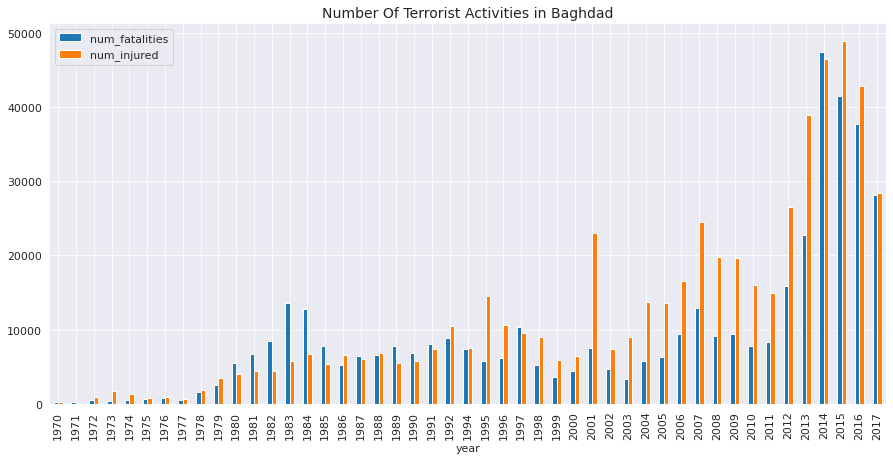

In [73]:
baghdad_casualities = GTA_df_new.groupby('year')['num_fatalities','num_injured'].sum()
baghdad_casualities.plot(kind='bar',figsize=(15, 7))
plt.title('Number Of Terrorist Activities in Baghdad',size = 14)
plt.show()

##### **Findings from the above graph combined with the war history**
* In  Baghdad, the priod <code>2011 - 17 had higher number of fatalities and wounds</code>.The city has faced severe damages during this time due to the <code>Iraq War</code> which is lasted  until 2011 and subsequent insurgency and renewed war that lasted until 2017.
* The attacks started <code>declining in 2017</code> mainly because of <code>territorial defeat of the Islamic State militant group.</code>
* From <code>2003 - 2011</code> is showing up & down trend in attack due to <code>United States invasion of Iraq</code> lasted during 2003-11.

### 9. According to the data, which are the top 25 countries currently at risk of increased terrorist activity?

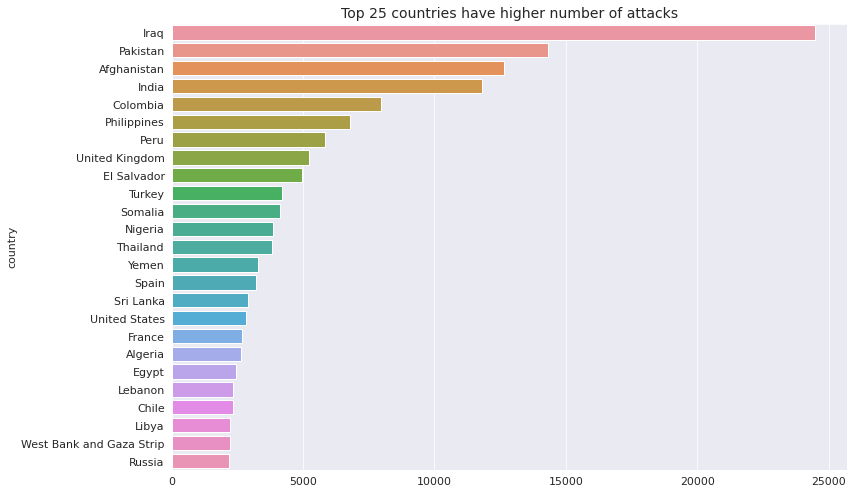

In [74]:
# Creating dataframe of targeted countries
target_countries = GTA_df_new.groupby('country').eventid.count().sort_values(ascending=False)[:25]

# Plotting values
plt.figure(figsize=(12, 7))
sns.barplot(x =target_countries.values,
            y = target_countries.index)
plt.title('Top 25 countries have higher number of attacks',size = 14)
plt.tight_layout()
plt.show()

##### **Findings from the above graph**
* <code>Iraq </code> is the <code>most targeted</code> country. 
* <code>followed by Pakisthan, Afganisthan and India</code>.
* <code>Iraq</code> is the <code>only one</code> country that attacked <code>more than 24,500 times</code> in the history. 
* Pakisthan, Afganisthan and India are attacked more than 10,000 times during 1970 -2017.
* Number of attacks had in Philippines + Peru = Number of attacks had in Afganisthan.
* Since the countries with the highest attacks are the mostly <code>densely populated</code>, the attacks in these countries may <code>claim more damages and lives</code>.

### 10. Discuss the impact of terrorism on the worst affected countries.
#### a. Terror activities  and related deaths & injuries

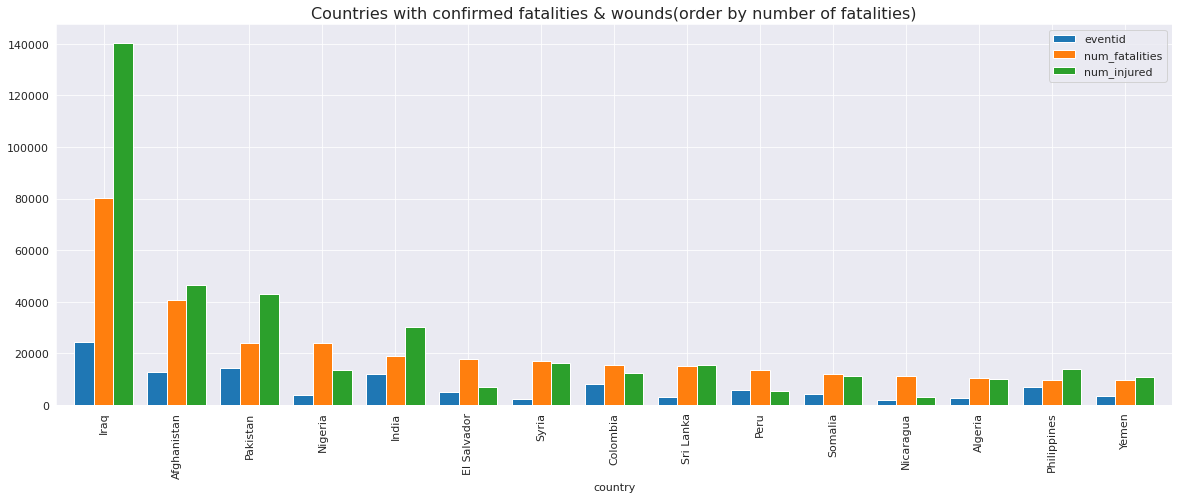

In [75]:
GTA_df_new.groupby(['country']).agg({'eventid':'count',
                                     'num_fatalities':'sum',
                                    'num_injured':'sum'
                                    }).sort_values(by ='num_fatalities', 
                                                   ascending= False)[:15].plot(kind = 'bar',
                                                                               width=0.8 ,
                                                                              figsize=(20, 7))
plt.title('Countries with confirmed fatalities & wounds(order by number of fatalities)',
         size = 16)
plt.show()

#### b.  Property Damages in the worst affected countries

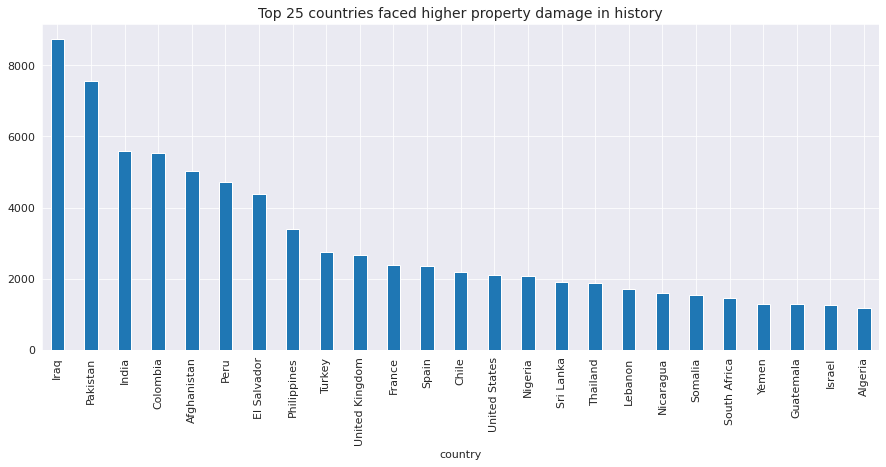

In [76]:
### top 25 countries faced higher property damage
plt.rcParams['figure.figsize'] = (15,6)
property_damage = GTA_df_new[GTA_df_new.property  == 1] 
property_damage.groupby('country')['property'].count().sort_values(ascending=False)[:25].plot(kind ='bar',
                                                                                               width=0.4)
plt.title('Top 25 countries faced higher property damage in history', size = 14)
plt.show()

##### **Findings from the above graph**
* The worst affected country Iraq had higher number of related deaths, injuries, property damages.
* The country had 80K confirmed fatalities which is almost 3-folds more than the attacks reported in the country.Confirmed wounds are 6 times larger than the number of attacks. 
* Afghanistan , Pakistan, India were also heavily impacted. 
* Nigeria had 4-th rank in terms of the number of fatalities, 12 rank in terms number of attacks & 5 rank for property damages.
* Both Nigeria & Pakistan had 24K fatalities. But Pakistan higher number of confirmed property damages & confirmed wounds.
* But the number of attacks in Nigeria was 3 folds smaller compared to the attacks in Pakistan. 

### 11. Death tolls with respect to year, country & region

In [77]:
# Death tolls with respect to year, country & region
fig = px.treemap(GTA_df_new, path=[px.Constant("Global terrorism(Countries/Years) - size is proportional with the number of fatalities"), 
                                   'country', 'year'], 
                            values='num_fatalities',
                            color='region', width=900, height=600, 
                            hover_data=['region'],
                  color_continuous_scale='Inferno')
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
# intractive plot for analysis
fig.show()

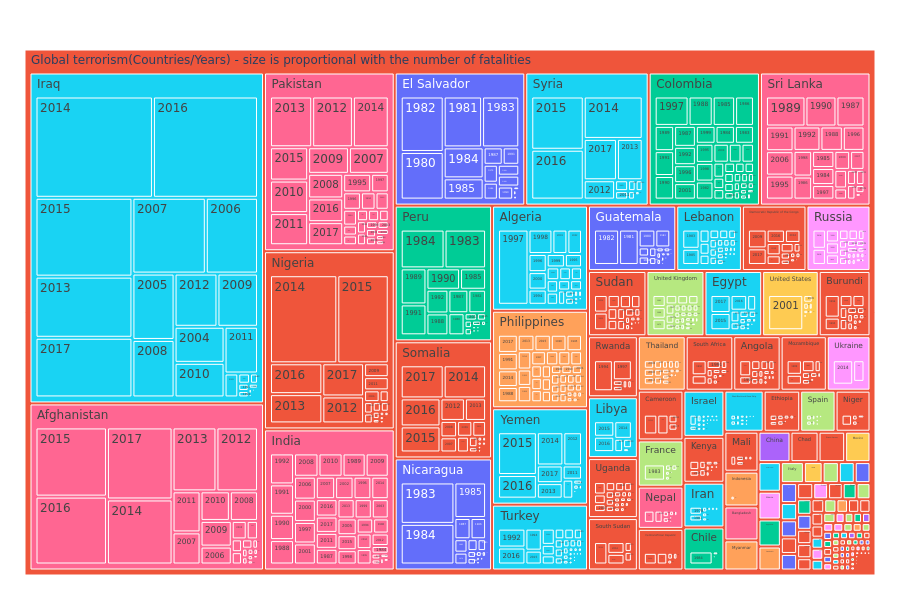

In [78]:
# Plot for showing in github 
fig.show('png')

##### **Findings from the above graph**
* The heavily affected countries such as Iraq, Afghanistan, Pakistan, Nigeria & Syria were majorly victimized in 20s.
* These deadliest periods are famously known by: 
 1. Syrian Civil War - The above tree map shows higher number of fatalities during 2014,2015 & 16 in Syria. 
 2. Iraq War  - Btw. 2013 -16 the above graph shows the evidence of higher number of fatalities compared to other time periods.<br> Aprox. 54% of overall attacks happeded in the country was during this time period.
 3. Afghanistan War - Between 2012 - 16 is showing higher number of fatalities Afghanistan.
 4. The War Against Boko Haram - Nigeria was victimized mostly after 2010. They had higher number of attacks in 2014 followed by 2015.
* India shows higher number of attacks in the late 90s and early 20s.
* El Salvador faced noxious attack during 1980 - 83 periods.This was the early periods of Salvadoran Civil War.

### 12. Worst affected countries Versus Rest of the world

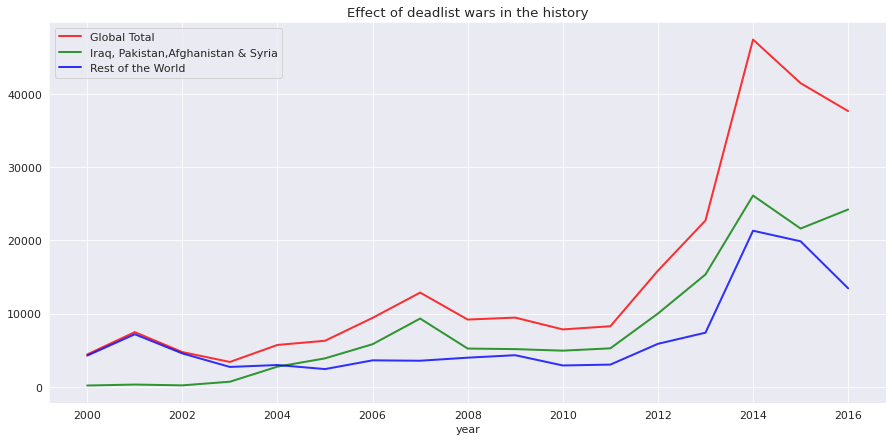

In [79]:
after_2000_df = GTA_df_new[GTA_df_new['year'].between(2000, 2016)]

top_wars_df = after_2000_df[(after_2000_df.country =='Iraq')|
                       (after_2000_df.country =='Pakistan')|
                       (after_2000_df.country =='Afghanistan')|
                       (after_2000_df.country =='Syria')]

remaining_world_df = after_2000_df[(after_2000_df.country !='Iraq')&
                       (after_2000_df.country !='Pakistan')&
                       (after_2000_df.country !='Afghanistan')&
                       (after_2000_df.country !='Syria')                                 ]

### plotting the data

plt.figure(figsize=(15, 7))
ax1 = plt.subplot(111)
after_2000_df.groupby('year')['num_fatalities'].sum().plot(kind='line',
                                                           ax=ax1,
                                                           color = 'red',alpha = 0.8,
                                                           sharex = True,
                                                           sharey = True,
                                                           linewidth=2,
                                                          label = 'Global Total')
top_wars_df.groupby('year')['num_fatalities'].sum().plot(kind='line',
                                                         color = 'green',
                                                         ax=ax1,alpha = 0.8,
                                                         sharex = True,
                                                         sharey = True,
                                                         linewidth=2 ,
                                                        label = 'Iraq, Pakistan,Afghanistan & Syria')
remaining_world_df.groupby('year')['num_fatalities'].sum().plot(kind='line',
                                                                linewidth=2 ,
                                                                ax=ax1,
                                                                sharex = True,
                                                                sharey = True,
                                                                color = 'blue',alpha = 0.8,
                                                               label = 'Rest of the World')
plt.title('Effect of deadlist wars in the history')
plt.legend()
plt.show()

##### **Findings from the above graph** 
* After 2005 , over 50% of global terrorism related deaths are reported from from Iraq,Pakistan,Afghanistan and Syria alone.
* In 2007, approx.72% of related deaths had been reported from Iraq,Pakistan,Afghanistan and Syria collectevely.

### 13. Compare the Regional Trends in Terrorism

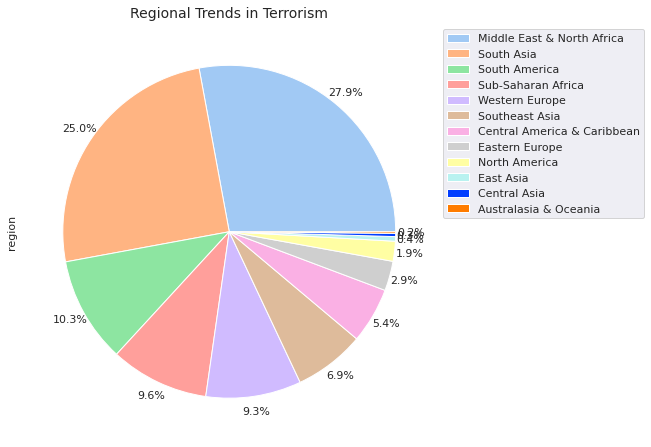

In [80]:
plt.figure(figsize=(9, 9))
colors = sns.color_palette('pastel')[0:10]+sns.color_palette('bright')[0:2]
GTA_df_new.region.value_counts().plot(kind='pie',
                                      autopct="%.1f%%",
                                      pctdistance= 1.09, 
                                      colors = colors,
                                      labels = None,
                                      rotatelabels=True,
                                      labeldistance=1)
plt.legend(labels =GTA_df_new.region.value_counts().index, 
                                                    bbox_to_anchor = (1,1),
                                                    loc = 2)
plt.title('Regional Trends in Terrorism',size = 14)
plt.tight_layout()
plt.show()

##### **Findings from the above graph**
* The regions <code>Middle East & North Africa and South Asia</code> collectevly cover <code>more than 52% </code>of attacks happended all over the world.
* <code>Middle East & North Africa</code> was the <code>top targeted</code> region in the history.
* <code>East Asia ,Central Asia and Australasia & Oceania collectevely contribute only < 1% of attacks</code> happended all over the world. 
* The region <code>Australasia & Oceania</code> is the <code>lowest targeted</code> region in the history.

### 14. Attacks, related deaths, wounds and total casualities per region

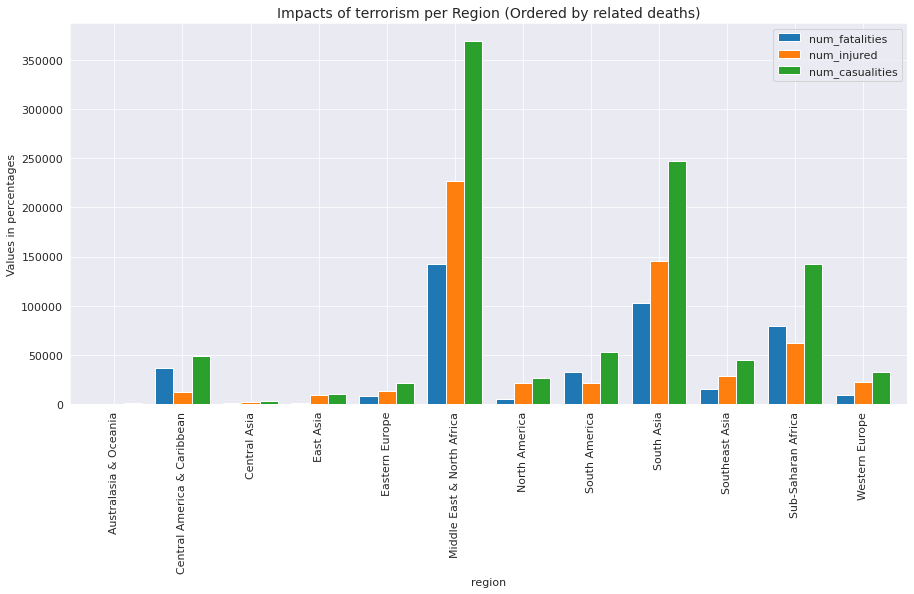

In [81]:
data_by_region = GTA_df_new.groupby('region')['num_fatalities','num_injured','num_casualities'].sum()

# plotting the values 
data_by_region.plot(kind = 'bar',width=0.8 ,figsize=(15, 7))
plt.title('Impacts of terrorism per Region (Ordered by related deaths)',size = 14)
plt.ylabel('Values in percentages')
plt.show()

In [82]:
# values in percentages
data_by_region.apply(lambda x: x/sum(x)*100, axis=0).sort_values(by = ['num_fatalities'])

,num_fatalities,num_injured,num_casualities
region,,,
Australasia & Oceania,0.037382,0.048363,0.043594
Central Asia,0.218295,0.342260,0.288422
East Asia,0.271369,1.639908,1.045556
North America,1.159085,3.835368,2.673068
Eastern Europe,1.913656,2.229651,2.092415
Western Europe,2.183409,3.993034,3.207121
Southeast Asia,3.577173,5.080755,4.427755
South America,7.426637,3.705337,5.321484
Central America & Caribbean,8.349429,2.209278,4.875922


##### **Findings from the above graph**
* <code>Middle East and North Africa</code> had the highest counts of death ,wounded and casualties. ie, <code>32.8% of global deaths & 40% of global related wounds</code>.
* Followed by <code>South Asia</code> with <code>25% of total global attacks</code> resulting in <code>23.5% of total related deaths</code> and <code>25.7% of related wounds.</code>
* <code>Sub-Saharan Africa had the 3rd position by having 18.3% of global deaths from 9.6% of global attacks.</code>
* <code>Australasia & Oceania</code> was the <code>least affected</code> region.
* Australasia & Oceania had only <code>0.03% of all terrorism deaths</code> and <code>0.04% of all terrorism wounds</code>.


### 15. Attacks by region and year

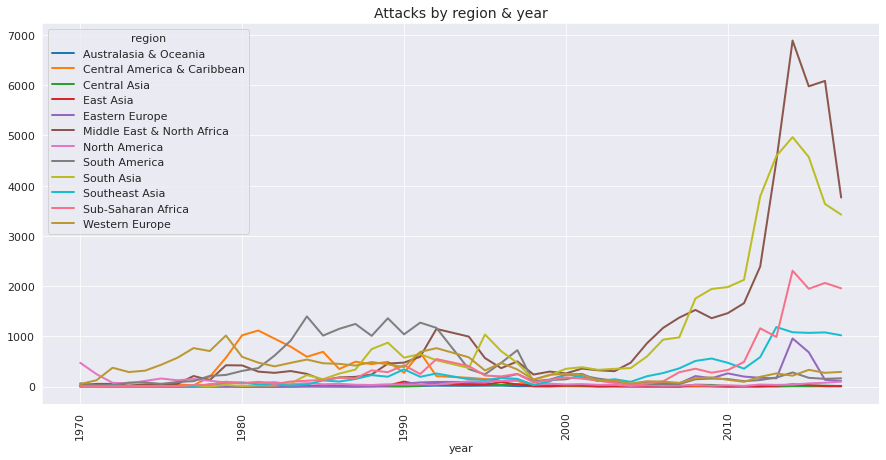

In [83]:
colors = sns.color_palette()[0:10]+ sns.color_palette('husl')[0:2]
pd.crosstab(GTA_df_new.year, GTA_df_new.region).plot(
                                                     kind='line',
                                                     stacked=False,
                                                     figsize=(15,7),
                                                     color = colors,
                                                     linewidth=2,
                                                     rot = 90)
plt.title('Attacks by region & year',size = 14)
plt.show()

##### **Findings from the above graph**
* Australasia & Oceania ,East Asia ,Central Asia are the regions that maintains low attacks during 1970-2017.This is because these regions may have most active counter-terror units to protect their citizens.
* Eastern Europe, Southeast Asia, Sub-Saharan Africa, South Asia and Middle East & North Africa were the top victims attacks after 2010. 
* None of the regions had not cross more than 1500 attaks before 2000.
* South America,Central America & Caribbean,Western Europe,Middle East & North Africa were the most fallen victim of attacks before 2000.
* South Asia and Middle East & North Africa had spike in 2014 when South Asia crossed approx. 4900 attacks & Middle East & North Africa crossed approx. 6800 attacks.

### 

### 16. Number of Successful and Unsuccessful attacks per year

In [84]:
plt.rcParams['figure.figsize'] = (15, 7)
fig = px.histogram(GTA_df_new, 
                   x='year', 
                   color = 'success', 
                   color_discrete_sequence=['green', 'grey'], 
                   title='Number of terrorist attack per year')
fig.update_layout(bargap=0.1)
fig.update_xaxes(tickangle= -90)
fig.show()

### 17. Methodes of attacks by count 

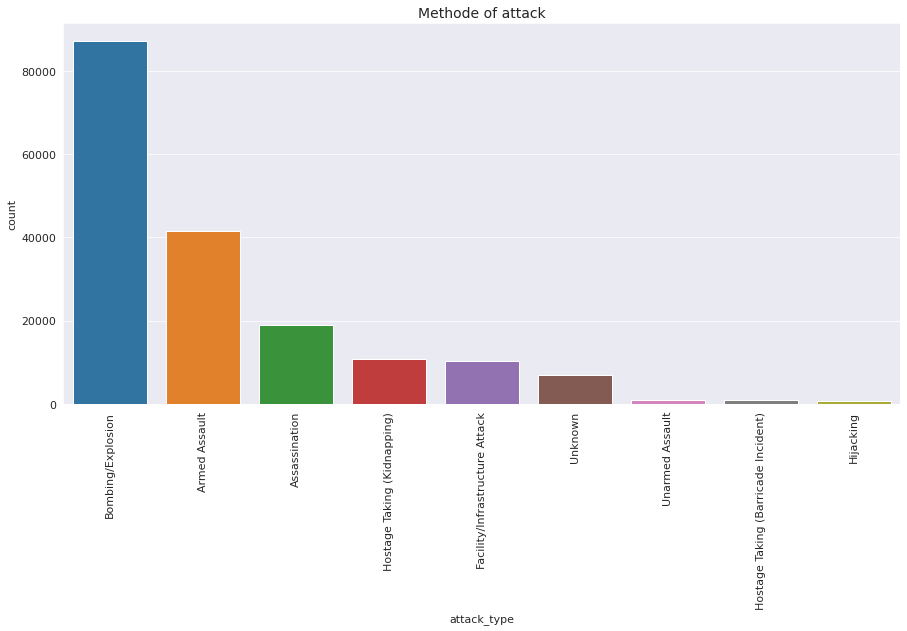

In [85]:
plt.rcParams['figure.figsize'] = (15, 7)
sns.countplot(x="attack_type", data= GTA_df_new, order=GTA_df_new.attack_type.value_counts().index)
plt.title('Methode of attack', size = 14)
plt.xticks(rotation=90)
plt.show()

##### **Findings from the above graph**
* Bombing/Explosion was the most prevalent method of attack that covered 49% of global attacks.
* Followed by Armed Assault and Assassination
* Hijacking,Unarmed Assault and Hostage Taking were the rare methods of attack (covers <1% of global attacks).
* Hijacking, Hostage Taking (Barricade Incident), and Unarmed Assault combined covers only 1.5% of global attacks.

### 18. Who has sufferred the most ?

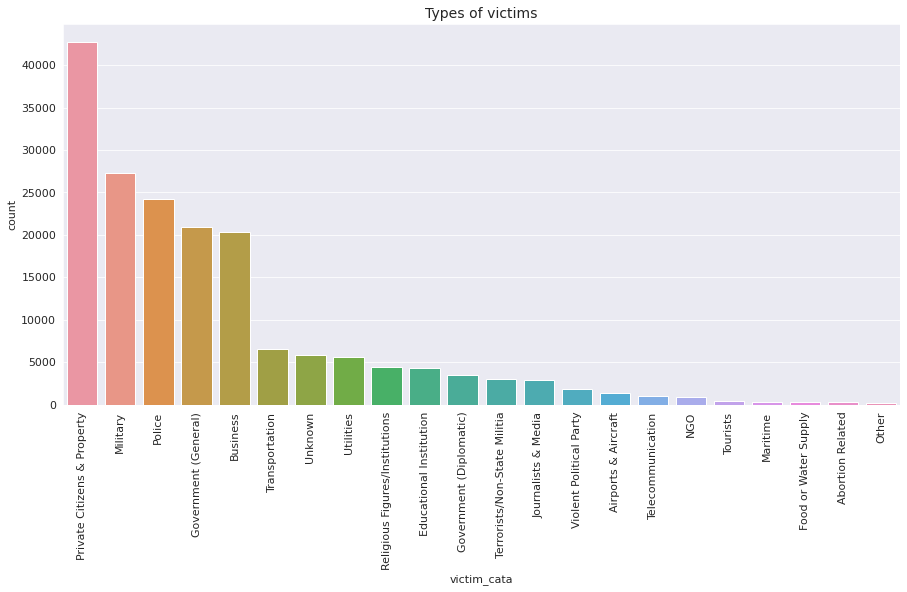

In [86]:
### types of victims of attack
plt.rcParams['figure.figsize'] = (15, 7)
sns.countplot(x="victim_cata", data= GTA_df_new, order=GTA_df_new.victim_cata.value_counts().index)
plt.title('Types of victims', size = 14)
plt.xticks(rotation=90)
plt.show()

In [87]:
GTA_df_new.victim_cata.value_counts()/len(GTA_df_new)*100

Private Citizens & Property       23.990834
Military                          15.295182
Police                            13.618059
Government (General)              11.750532
Business                          11.425891
Transportation                     3.694613
Unknown                            3.277860
Utilities                          3.146993
Religious Figures/Institutions     2.468505
Educational Institution            2.401105
Government (Diplomatic)            1.975927
Terrorists/Non-State Militia       1.674315
Journalists & Media                1.606354
Violent Political Party            1.034020
Airports & Aircraft                0.737462
Telecommunication                  0.562224
NGO                                0.529647
Tourists                           0.237583
Maritime                           0.178609
Food or Water Supply               0.169622
Abortion Related                   0.147717
Other                              0.076948
Name: victim_cata, dtype: float6

### 19. Top 25 active terror groups in history

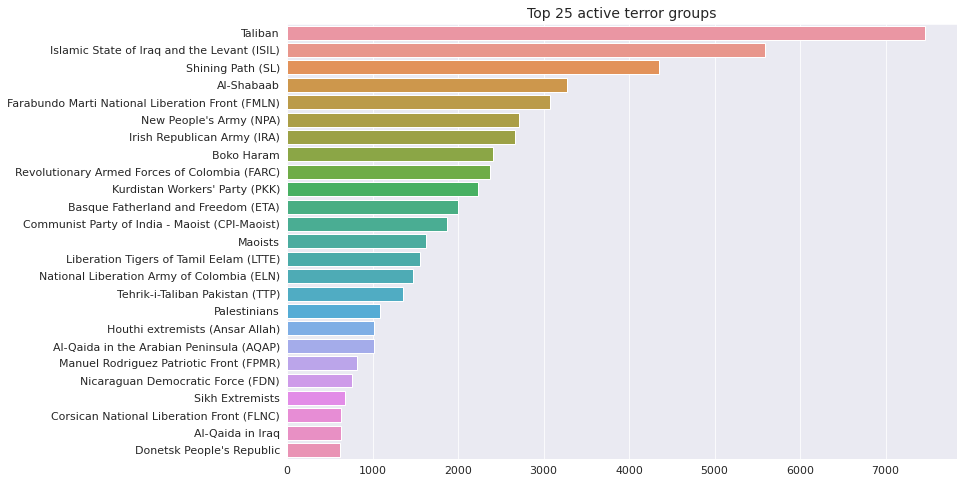

In [88]:
plt.rcParams['figure.figsize'] = (12, 8)
active_groups = GTA_df_new[GTA_df_new['perpetrator_group'] !='Unknown']
sns.barplot(active_groups['perpetrator_group'].value_counts()[:25].values,active_groups['perpetrator_group'].value_counts()[:25].index)
plt.title('Top 25 active terror groups', size = 14)
plt.show()

In [89]:
(GTA_df_new['perpetrator_group'].value_counts()/len(GTA_df_new)*100)[:25]

Unknown                                             45.856338
Taliban                                              4.188876
Islamic State of Iraq and the Levant (ISIL)          3.136321
Shining Path (SL)                                    2.439860
Al-Shabaab                                           1.840567
Farabundo Marti National Liberation Front (FMLN)     1.725426
New People's Army (NPA)                              1.524351
Irish Republican Army (IRA)                          1.495144
Boko Haram                                           1.352482
Revolutionary Armed Forces of Colombia (FARC)        1.336194
Kurdistan Workers' Party (PKK)                       1.252506
Basque Fatherland and Freedom (ETA)                  1.122201
Communist Party of India - Maoist (CPI-Maoist)       1.053678
Maoists                                              0.913824
Liberation Tigers of Tamil Eelam (LTTE)              0.875070
National Liberation Army of Colombia (ELN)           0.829013
Tehrik-i

##### **Findings from the above graph**
* Taliban was the most active group in history. Around 4% of global attacks were led by the Taliban alone.
* Followed by ISIL at second rank with 3% of global attacks and Shining Path(SL) at third rank with 2.4% of global attacks.

### 20. Attacks by top 3 ranked groups over the years

In [90]:
Top_3_groups_df = GTA_df_new[(GTA_df_new['perpetrator_group'] =='Taliban')|
           (GTA_df_new['perpetrator_group'] =='Islamic State of Iraq and the Levant (ISIL)')|
           (GTA_df_new['perpetrator_group'] =='Shining Path (SL)')]
plt.rcParams['figure.figsize'] = (15, 7)

fig = px.histogram(Top_3_groups_df, 
                   x='year', 
                   color = 'perpetrator_group', 
                   title='Attacks by top 3 ranked groups')

fig.update_layout(bargap=0.1)
fig.update_xaxes(tickangle= -90)
fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1),
    bargap=0.1)
# intractive plot
fig.show()

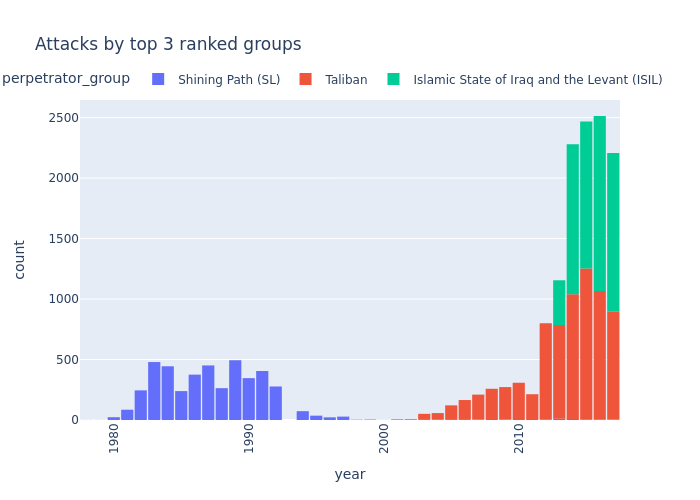

In [91]:
# for github show
fig.show('png')

##### **Findings from the above graph**
* First attack of Shining Path(SL) was in 1978.
* Shining Path(SL) has grown into the deadliest terror group by doing several attacks during 1980-1997.
* After 1992, there is a significant reduction in attacks initiated by SL lowering from 277 to 73.
* Shining Path(SL) has done more than 400 attacks during the years 1983,1984,1987,1989 and 1991.
* In 1989 they have done 494 attacks which were the top attacks done by them in a year.
* ISIL has done their first attack in 2013 and in the same year, they have done 370 attacks.
* From 2013 -17 they have done more than 1000 attacks in a year.
* Taliban’s first attack was in 1995.
* After that there is an  exponential growth of the attacks by them during 2003-17


### 21. Top 3  acive groups and their countries 

In [92]:
df = Top_3_groups_df.groupby(['perpetrator_group','country']).agg({'eventid':'count','num_fatalities':'sum',
                                                                     'num_injured':'sum',
                                                                      'year':set})
df = df.sort_values('eventid',ascending= False)
df.head()

eventid  \
perpetrator_group                           country                
Taliban                                     Afghanistan     7403   
Islamic State of Iraq and the Levant (ISIL) Iraq            4781   
Shining Path (SL)                           Peru            4331   
Islamic State of Iraq and the Levant (ISIL) Syria            584   
                                            Turkey            82   

                                                         num_fatalities  \
perpetrator_group                           country                       
Taliban                                     Afghanistan           30342   
Islamic State of Iraq and the Levant (ISIL) Iraq                  32418   
Shining Path (SL)                           Peru                  12103   
Islamic State of Iraq and the Levant (ISIL) Syria                  7352   
                                            Turkey                  416   

                                                         num_injured  \
perpetrator_group                           country                    
Taliban                                     Afghanistan        29598   
Islamic State of Iraq and the Levant (ISIL) Iraq               25381   
Shining Path (SL)                           Peru                4195   
Islamic State of Iraq and the Levant (ISIL) Syria               4881   
                                            Turkey              1274   

                                                                                                      year  
perpetrator_group                           country                                                         
Taliban                                     Afghanistan  {2016, 2017, 1995, 2001, 2002, 2003, 2004, 200...  
Islamic State of Iraq and the Levant (ISIL) Iraq                            {2016, 2017, 2013, 2014, 2015}  
Shining Path (SL)                           Peru         {1978, 1979, 1980, 1981, 1982, 1983, 1984, 198...  
Islamic State of Iraq and the Levant (ISIL) Syria                           {2016, 2017, 2013, 2014, 2015}  
                                            Turkey                          {2016, 2017, 2013, 2014, 2015}

##### **Findings from the above graph**
* Afghanistan was the top most vctim of the Taliban with 7403 attacks that cause 30342 deaths and 29598 wounds.
* Taliban was active only in three countries including Afghanistan named Pakistan and Turkmenistan.
* Islamic State of Iraq and the Levant (ISIL) was most active in Iraq. They have done 4781 attacks during the time that led to 32418 deaths and 25381 wounds uring the period 2013 -17.
* followed by Syria with 584 attacks and Lebanon with 50 attacks and so on. 
* Shining Path (SL) was mostly active in Peru with 4331 that cause 12103 deaths and 4195 wounds.

### 22. Methode of attack VS duration of attack

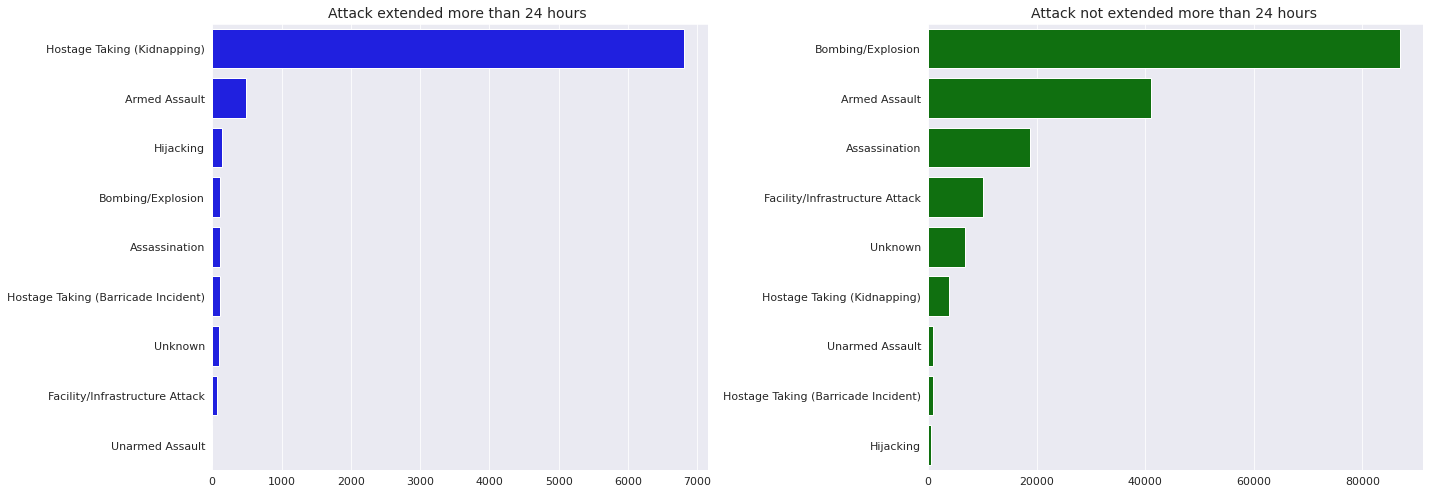

In [93]:
extended_attack_df = GTA_df_new[GTA_df_new['extended'] == 1]
non_extended_attack_df = GTA_df_new[~ (GTA_df_new['extended'] == 1)]

plt.figure(figsize=(20, 7))
ax1 = plt.subplot(121)
sns.barplot(extended_attack_df['attack_type'].value_counts().values,extended_attack_df['attack_type'].value_counts().index, color='blue')
ax1.set_title('Attack extended more than 24 hours ',size = 14)
ax2 = plt.subplot(122)
sns.barplot(non_extended_attack_df['attack_type'].value_counts().values,non_extended_attack_df['attack_type'].value_counts().index, color='green')
ax2.set_title('Attack not extended more than 24 hours ',size = 14)
plt.tight_layout()
plt.show()

In [94]:
(extended_attack_df['attack_type'].value_counts()/len(extended_attack_df))*100

Hostage Taking (Kidnapping)            85.761089
Armed Assault                           6.060988
Hijacking                               1.789315
Bombing/Explosion                       1.449093
Assassination                           1.386089
Hostage Taking (Barricade Incident)     1.348286
Unknown                                 1.247480
Facility/Infrastructure Attack          0.932460
Unarmed Assault                         0.025202
Name: attack_type, dtype: float64

In [95]:
(non_extended_attack_df['attack_type'].value_counts()/len(non_extended_attack_df))*100

Bombing/Explosion                      51.097251
Armed Assault                          24.151857
Assassination                          11.072443
Facility/Infrastructure Attack          5.959778
Unknown                                 4.044513
Hostage Taking (Kidnapping)             2.303256
Unarmed Assault                         0.579047
Hostage Taking (Barricade Incident)     0.505564
Hijacking                               0.286290
Name: attack_type, dtype: float64

##### **Findings from the above graph**
* More than 85% of cases if an attack is extended more than 24 hours, are reported as Hostage Taking (Kidnapping).
* Followed by Armed Assault  with 6% of chances.
* Attacks by Unarmed Assault very rarely extend more than 24 hours.
* Hijacking ,Bombing/Explosion ,Assassination and Hostage Taking (Barricade Incident) have equal chances to extend more than in a day. (have <2% chances).
* If an attack does not extend more than 24 hours, approx. 50% of cases have been reported by Bombing/Explosion.
* Followed by Armed Assault with 24% ,Assassination with 11% 
* Unarmed Assault, Hostage Taking (Barricade Incident), and Hijacking are the rarely reported method for attacks within  24 hours.

## **Ask & answer questions**

#### Ask & answer questions
1. What percentage of total attacks had extended more than 24 hours?
2. Percentage of successful and unsuccessful attacks
3.  Do the trend in attacks vary with respect to month?
4. Identify the trend in attack over the years. Which year had the highest & lowest number of attacks?
5. Comment the global impact of terrorism with appropriate visualization.
6. Identify the top 50 targeted cities in the history
7. Identify top 5 active terrorist groups in the most affected city?
8. Compare the outcomes (number of fatalities & wounds) of most victimized city. Identify the years with the least & most casualties in the city. Discuss the reasons.
9. According to the data, which are the top 25 countries currently at risk of increased terrorist activity?
10. Discuss the impact of terrorism on the worst affected countries.
11. Death tolls with respect to year, country & region
12. Compare the Worst affected countries Versus Rest of the world
13. Which region was the most fallen victim of attacks? Which region has the lowest?
14. What are the regions containing the highest and the lowest related deaths?. Compare casualties, the death toll, and number of wounds in each region.
15. Compare the trend in attack in each region with respect to the time?
16. Number of Successful and Unsuccessful attacks per year
17. What kinds of weapons are used in terror attacks?
18. Who are the common victims of terror attacks?
19. Who are the top 25 active terror groups?
20. Identify the attacks by top 3 ranked groups over the years
21. Find out the targeted countries of the top 3 active groups in history. Comment your findings.
22. Explore the variable 'extended' with respect to the method of attack.

## **Summary and Conclusions**
#### **Insights:**
* Last 6 years in the data (2012 -17) are found to be the most prominent periods of attacks according to the data. Global terrorism peaked in 2014 with more than 16,700 attacks in a single year, followed by the year 2015 with more than 14,000 attacks. The year 1971 had the least number of attacks in the globe with 463 attacks.
* All three: the number of fatalities, number of wounds, and total number of attacks are interconnected.  It makes sense that the last 6 years in the data had the highest number of related deaths, wounds, and property damages. 
* The impact of terrorism reached its peak in 2014.  From 2011-14, the number of attacks increased to 232%, related deaths increased to 474%, confirmed wounds increased to 212% and property damages increased to approx.193%.  Although related deaths & property damages have declined since 2015 with respect to the number of attacks but related wounds have increased to 5% from 2014.
* Baghdad city, the capital of Iraq has experienced the highest level of terrorism in the globe with more than 7500 incidents. Followed by Karachi in Pakisthan, Lima in Peru, Mosul, and Belfast victimized more than 2000 times. Karachi, Lima, and Mosul collectively had fewer attacks than Baghdad city alone faced.
* Baghdad city was severely victimized over the last 6 years. More than 46% of total related deaths in the city were reported during these periods. Since the government is not able to find the terror group responsible for 86% of the attacks that happened in the city, we can confirm wars in the specified period. The city has faced severe damages during this time due to the Iraq War which lasted until 2011 and subsequent insurgency and renewed war that lasted until 2017. The effect of the United States invasion of Iraq (which lasted from 2003-11) is also clearly visible in the graph.
* Iraq was the most affected country by terrorism in history, followed by Pakistan, Afghanistan, India, Colombia, Philippines, Peru, and so on. Iraq alone was victimized more than 24,500 times throughout the time period 1970 – 2017 had more than 80K related deaths which is almost 3 folds more than the attacks that happened in the country. Related wounds in the country were 6 times more than the number of attacks.
* Pakistan, Afghanistan & Nigeria also had more than 24k fatalities. Nigeria had a higher number of fatalities compared to the lesser number of attacks. Since the most victimized countries are densely populated, it makes sense that attacks in these countries claim more lives.
* Iraq, Afghanistan, Pakistan, Nigeria & Syria are severely victimized in the 20s. This period of time is famously known as the Syrian Civil War, Iraq War, Afghanistan War, and The War Against Boko Haram. India shows a higher number of attacks in the late 90s and early 20s. 
* From 2005 onwards, more than 50% of global terrorism-related deaths are reported from Iraq, Pakistan, Afghanistan, and Syria only. In 2007 alone, approximately 72% of global terrorism-related deaths had been reported from these countries only.
* There are 12 categorized regions are there in the data. The Middle East and North Africa is the most affected region by terrorism where 27.9% of total global attacks had been reported resulting in over 32% of all terrorism deaths and over 40% of all terrorism wounds had been recorded.  Followed by South Asia with 25% of total global attacks resulting in 23.5% of total related deaths and 25.7% of related wounds. However, the majority of the attacks have been recorded after the year 2000. Since most targeted countries are from this region the above findings make sense.
* It is really appreciable that East Asia, Central Asia, and Australasia & Oceania are the most peaceful regions in the globe according to the data. These regions collectively contribute only less than 1% of attacks happening all over the world. Especially the region Australasia & Oceania had only 0.03% of all terrorism deaths and 0.04% of all terrorism wounds.
 This may be because:
  1. These regions include countries that have the most active counter-terror units to protect their citizens. 
  2. consists of countries that are least densely populated.
* Bombing/Explosion was found to be the most prevalent method of attack that covered 49% of global attacks, followed by Armed Assault and Assassination. Hijacking, Unarmed Assault and Hostage Taking were the rare methods of attack (covers <1% of global attacks). Implementing more securities for disarmament or bomb detection over countries will be more beneficial for reducing terrorism related violence and its consequences.
* Approximately 24% of victims of terrorism were 'Private Citizens & Property' followed by the 'Military' with 15% and police with 13.6%. It makes sense. Since war is always a conflict between countries and groups, the Military, Citizens & Property will be the top victims of fire and explosions always. 
* Taliban is found to be the most active deadliest group in history and was responsible for 4% of total global terror attacks. Taliban’s first attack was on 1995 . During 20s they have grown into most deadliest group in Afghanistan with 7403 attacks that cause 30342 deaths and 29598 wounds.
* The newly emerged group in 2013 , Islamic State of Iraq and the Levant (ISIL) who is responsible for 3% of total global terror attacks was the second deadliest group in the history. The group was severly active on Iraq during 2013 -17.
* The 3rd ranked group  Shining Path (SL) with 2.4%  total global terror attacks  was the most deadliest group during 1980-1997. After 1992, there is a significant reduction in attacks initiated by SL lowering from 277 to 73. Peru was the most fallen victim of SL.
* Followed by Al-Shabaab in 4th rank with 1.8% total global terror attacks , Farabundo Marti National Liberation Front (FMLN) in 5th rank with 1.7% of total attacks and so on.
* According to the data, if an attack is extended more than 24 hours , 85% of chances that the attacks will be Hostage Taking (Kidnapping) and 6% chances for  Armed Assault. On the other hand if an attacks is not extended more than 24 hours, in 50% of cases the method of attack will be Bombing/Explosion. Unarmed Assault, Hostage Taking (Barricade Incident), and Hijacking are the rarely reported method for attacks within 24 hours.
